In [8]:
import numpy as np
import matplotlib.pyplot as plt
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
from chainer.dataset import concat_examples
import chainer.functions as F
import chainer.links as L
import utils

In [9]:
train_data, test_data = utils.get_mnist(n_train=1000, n_test=0, with_label=False, classes = [0], n_dim=2)

In [10]:
class Discriminator(Chain):
    def __init__(self, n_out=1):
        super(Discriminator, self).__init__()
        with self.init_scope():
            self.conv = L.Convolution2D(
                in_channels=1, out_channels=5, ksize=5, stride=1, pad=0)
            self.fc = L.Linear(24*24*5, n_out)

    def __call__(self, x):
        h = F.relu(self.conv(x))
        if chainer.config.train:
            return self.fc(h)
        return self.fc(h)

In [11]:
class Generator(chainer.Chain):

    def __init__(self, n_hidden=10, bottom_width=26, ch=10):
        super(Generator, self).__init__()
        self.n_hidden = n_hidden
        self.ch = ch
        self.bottom_width = bottom_width

        with self.init_scope():
            self.l0 = L.Linear(self.n_hidden, bottom_width * bottom_width * ch)
            self.dc0 = L.Deconvolution2D(in_channels=ch, out_channels=1, ksize=3, stride=1, pad=0)
            self.bn0 = L.BatchNormalization(bottom_width * bottom_width * ch)

    def make_hidden(self, batchsize):
        return np.random.uniform(-1, 1, (batchsize, self.n_hidden, 1, 1)).astype(np.float32)

    def __call__(self, x):
        h = F.reshape(F.relu(self.bn0(self.l0(x))),
                      (len(x), self.ch, self.bottom_width, self.bottom_width))
        y = F.sigmoid(self.dc0(h))
        return y

In [12]:
gen = Generator()
gen_optimizer = optimizers.SGD()
gen_optimizer.setup(gen)

dis = Discriminator()
dis_optimizer = optimizers.SGD()
dis_optimizer.setup(dis)

In [13]:
batchsize = 50
max_epoch = 20
train_iter = iterators.SerialIterator(train_data, batchsize)
while train_iter.epoch < max_epoch:

    real_train = concat_examples(train_iter.next())
    real_train = np.expand_dims(real_train, axis=1)
    fake_train = gen(gen.make_hidden(batchsize))
    
    y_real = dis(real_train)
    y_fake = dis(fake_train)
    
    dis_loss = F.mean(-F.log(y_real) - F.log(1 - y_fake))
    gen_loss = F.mean(-F.log(y_fake))
    
    
    dis.cleargrads()
    dis_loss.backward()
    dis_optimizer.update()
    gen.cleargrads()
    gen_loss.backward()
    gen_optimizer.update()
    
    if train_iter.is_new_epoch:
        print(train_iter.epoch)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


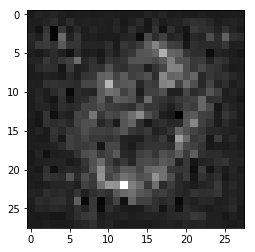

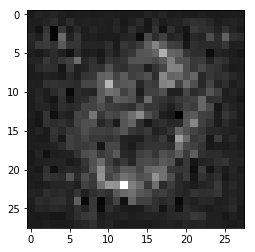

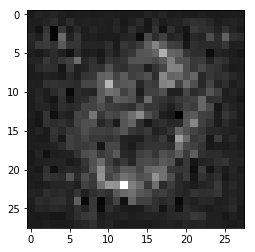

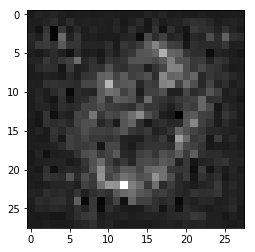

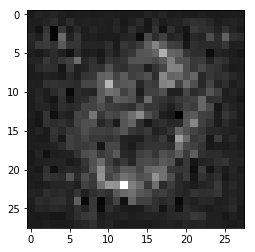

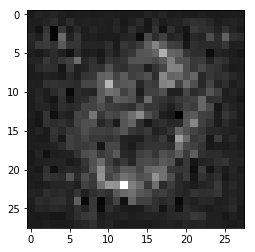

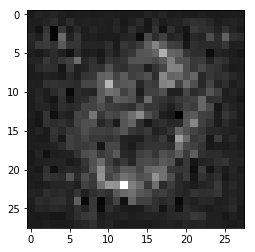

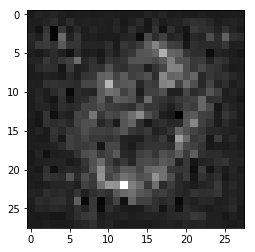

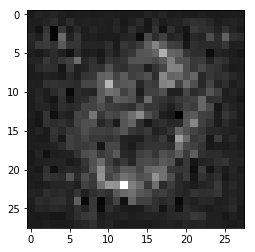

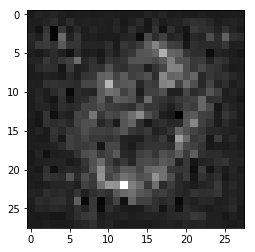

In [14]:
for i in range(10):
    y = gen.make_hidden(1)
    x = gen(y).data
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.show()